In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
from ontological_processor import OntologicalProcessor
from preprocess_transcription import Preprocessor
from callsign_matcher import CallsignMatcher

# Loading Data in a Different Way

In [20]:
df = pd.read_json('../sample_transcriptions/transcriptions_122021.json')

In [21]:
df = df[['id', 'endDate', 'utterance']]

In [ ]:
df = df['utterance']

In [22]:
df.head()

,id,endDate,utterance
0,0BD65F98-25BE-4544-A6CC-5EBBA62B217F,6.575037e+08,AMERICAN 919 HEADING 150 JOIN YOUR FINAL CLEAR...
1,B096F173-D10C-4D97-A60A-02F771F14136,6.575044e+08,RIGHT ON
2,E87E6DE3-C475-45F4-BD7F-E8E6703B29C5,6.575045e+08,6025
3,BB620707-F0C6-44D4-991F-C356F344B390,6.575537e+08,OKAY
4,2C417B50-DC91-4DAC-A57C-A21065DD5C45,6.575555e+08,


# Loading Data

In [16]:
#link_to_stuff = '../sample_transcriptions/2021-12-20.txt'
link_to_stuff = '../sample_transcriptions/transcriptions_122021.json'

proc = Preprocessor(link_to_stuff, log=False)

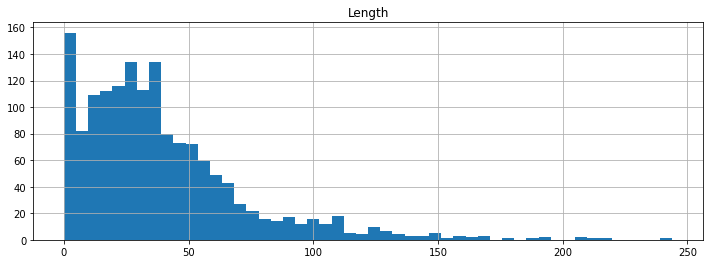

In [17]:
proc.plot_length_distribution()

In [18]:
df = proc.get_transcriptions(15)

In [19]:
df.to_csv('test.csv', index=False)

# Processing

In [20]:
op = OntologicalProcessor()

flight_data_link = '../flight_data/12-20-21/12-20-21.csv'
cm = CallsignMatcher(flight_data_link)

In [21]:
df_track = pd.read_csv(flight_data_link)

In [22]:
from time import time
from datetime import datetime

In [23]:
def strip_time(x):
    if x: 
        return int(x) + 978307200
    else: 
        return -1

In [24]:
"""
NOTE: only use this function with the log based data frame

def strip_time(x):
    try: 
        return int(datetime.strptime(x[:-4], '%y-%m-%d %H:%M:%S').timestamp())
    except: 
        return -1"""

"\nNOTE: only use this function with the log based data frame\n\ndef strip_time(x):\n    try: \n        return int(datetime.strptime(x[:-4], '%y-%m-%d %H:%M:%S').timestamp())\n    except: \n        return -1"

In [25]:
df['Time'] = df['Time'].apply(strip_time)

<ipython-input-25-8bab53099a43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df['Time'].apply(strip_time)


In [43]:
df['altitude'] = df['Transcriptions'].apply(op.find_alt)
df['heading'] = df['Transcriptions'].apply(op.find_turn)
df['speed'] = df['Transcriptions'].apply(op.find_speed)
df['contact'] = df['Transcriptions'].apply(op.find_contact)
df['clearance'] = df['Transcriptions'].apply(op.find_clearance)
df['callsign'] = df['Transcriptions'].apply(op.find_callsign)
df['callsign_matched'] = df.apply(lambda x: cm.find_match(callsign = x['callsign'], t = x['Time'], c = 30000), axis=1)

<ipython-input-43-e106167cc95a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['altitude'] = df['Transcriptions'].apply(op.find_alt)
<ipython-input-43-e106167cc95a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heading'] = df['Transcriptions'].apply(op.find_turn)
<ipython-input-43-e106167cc95a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

(array([464], dtype=int64),)
(array([588], dtype=int64),)
(array([588], dtype=int64),)
(array([ 21, 228, 234, 244, 253, 317, 446, 473, 489, 743], dtype=int64),)
(array([304], dtype=int64),)
(array([ 69, 295, 328, 386, 429, 465, 499, 574, 630, 787, 809], dtype=int64),)
(array([31], dtype=int64),)
(array([69], dtype=int64),)
(array([702], dtype=int64),)
(array([702], dtype=int64),)
(array([ 32, 170, 268, 311, 367, 525, 701, 708, 724, 740], dtype=int64),)
(array([702], dtype=int64),)
(array([702], dtype=int64),)
(array([ 32, 170, 268, 311, 367, 525, 701, 708, 724, 740], dtype=int64),)
(array([ 32, 170, 268, 311, 367, 525, 701, 708, 724, 740], dtype=int64),)
(array([432, 731], dtype=int64),)
(array([702], dtype=int64),)
(array([702], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=int64),)
(array([67], dtype=in

<ipython-input-43-e106167cc95a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['callsign_matched'] = df.apply(lambda x: cm.find_match(callsign = x['callsign'], t = x['Time'], c = 30000), axis=1)


In [27]:
df.to_csv('test.csv', index=False)

In [44]:
df['callsign_matched'].value_counts()



NA          927
AAL566       13
AAL2047      13
ENY3546      10
ENY3575      10
           ... 
AAL2733       1
AAL681        1
AAL2327       1
SKW3119       1
AAL1148       1
Name: callsign_matched, Length: 66, dtype: int64

In [30]:
df['callsign_matched'].value_counts()

NA          963
AAL566       13
AAL1047      12
AAL1754      11
AAL751       10
           ... 
AAL2733       1
AAL869        1
ENY3569       1
AAL681        1
AAL819        1
Name: callsign_matched, Length: 69, dtype: int64

In [28]:
df['callsign_matched'].value_counts()

NA          976
AAL566       14
AAL1047      12
AAL1754      11
AAL1188      10
           ... 
ENY4248       1
AAL2733       1
ENY3569       1
AAL681        1
AAL819        1
Name: callsign_matched, Length: 63, dtype: int64

# Looking at One Example

In [18]:
aal566_commands = df[df['callsign_matched'] == 'AAL566  ']

In [20]:
aal566_track = df_track[df_track['callsign'] == 'AAL566  ']

In [22]:
aal566_commands

,Time,Transcriptions,Length,altitude,heading,speed,contact,clearance,callsign,callsign_matched
499,21-12-20 17:56:46.016,REGIONAL APPROACH AMERICAN 566 IS WITH YOU OUT...,58,NA,NA,NA,False,False,AAL566,AAL566
500,21-12-20 17:57:47.792,AMERICAN 566 REGIONAL APPROACH 18 RIGHT,39,NA,Missing ST,NA,False,False,AAL566,AAL566
506,21-12-20 18:04:19.608,AMERICAN 566 TURN RIGHT HEADING 360 DESCEND AN...,106,4000,360,NA,False,False,AAL566,AAL566
509,21-12-20 18:04:39.584,AMERICAN 566 DESCEND AND MAINTAIN 3000,38,3000,NA,NA,False,False,AAL566,AAL566
510,21-12-20 18:05:26.038,3000 AMERICAN 566,17,Possibly Missing KW,NA,NA,False,False,AAL566,AAL566
513,21-12-20 18:06:01.972,AMERICAN 566 NO ALTITUDE MAINTAIN 4000,38,4000,NA,NA,False,False,AAL566,AAL566
514,21-12-20 18:06:05.844,4000 AMERICAN 566 UNITED 2215 DESCEND AND MAIN...,55,3000,NA,NA,False,False,AAL566,AAL566
515,21-12-20 18:06:19.750,OUT OF 4 FOR 3926 AMERICAN 566 TURN RIGHT HEAD...,140,NA,536,NA,True,False,AAL566,AAL566
520,21-12-20 18:06:59.561,AMERICAN 566 HEAVY AIRPORT AT YOUR AH 2 OCLOCK...,59,NA,NA,NA,False,False,AAL566,AAL566
521,21-12-20 18:07:10.047,FIELD IN SIGHT FOR 566 AMERICAN 566 TURN RIGHT...,94,NA,150,NA,False,True,AAL566,AAL566


In [35]:
aal566_commands.to_csv('aal566_command.csv', index=False)

In [32]:
aal566_track['time'] = aal566_track['time_position'].apply(lambda x: localtime(x))

<ipython-input-32-8a98ba221948>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aal566_track['time'] = aal566_track['time_position'].apply(lambda x: localtime(x))


In [34]:
aal566_track.to_csv('aal566_track.csv', index=False)

In [10]:
df['heading'].value_counts()

NA            590
Missing ST    171
150            36
200            16
090             9
220             9
10right         8
270             8
310             4
10left          4
070             4
230             4
280             3
340             3
350             3
170             3
152             2
130             2
010             2
100             2
120             2
240             2
360             2
250             2
160             1
190             1
566             1
355             1
20turn          1
332             1
536             1
790             1
219             1
260             1
030             1
564             1
320             1
235             1
646             1
020             1
110             1
751             1
080             1
Name: heading, dtype: int64

In [8]:
string = df['Transcriptions'].iloc[2]

In [10]:
import re

In [16]:
string

'AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY'

# Test Code (delete later)

In [22]:
string_1 = '1808 REDUCE SPEED TO 1 9 0'

while (string_1 != re.sub(r'\d+\s+\d+', change, string_1)):
    string_1 = re.sub(r'\d+\s+\d+', change, string_1)

# regex expression for one digit followed by one space followed by one digit

In [72]:
def find_alt(command):
    command = str.lower(command)
    command = str.split(command)

    number_loc = [i for (i, x) in enumerate(command) if x.isdigit() and (len(x) > 3) and (int(x)%100 == 0)] # Note: the divisibility by 100 excludes speed (and often callsigns)

    # locate the index of ascend
    key_loc = [i for (i, x) in enumerate(command) if (x == 'up') or ('down' in x) or ('descend' in x) or ('ascend' in x) or ('climb' in x) or ('altitude' in x) or ('maintain' in x)]

    # If there exists no keyword, there exists a number devisible by 100 
    if ((len(key_loc) == 0) and (len(number_loc) > 0)):
        return 'Missing KW' # NOTE: this can be used to predict speaker role w/ ML
    # If there exists no number and no command (note: doesn't account for edge case of callsign being divisible by 100)
    elif (len(key_loc)==0):
        return 'NA'
    # key_loc must be populated, but unsure about whether number_loc exists / actual altitude exists
    try:
        filtered_numbers = [i for i in number_loc if i > key_loc[-1]]
        return int(command[filtered_numbers[0]])
    # If above fails, must be because altutde does not exist but keyword exists
    except:
        return 'Missing ST'

    # TODO: use NLTK synonyms instead

In [53]:
find_alt(df['Transcriptions'].iloc[4])

7000

In [44]:
command = df['Transcriptions'].iloc[2]
print(find_alt(command))

AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY
['american', '1583', 'maintain', '180', 'knots', 'to', 'zalpo', 'contact', 'tower', 'now', '127.5', 'have', 'ah', 'good', 'day']
[1]
[2]
None


In [75]:
df

,Time,Transcriptions,Length,altitude,turn
51,21-11-02 07:14:45.389,DELTA 1169 APPROACH GOOD MORNING 35 RIGHT,41,True,True
52,21-11-02 07:14:45.698,AMERICAN 1583 AH MILES FROM 3 MAINTAIN 3000 UN...,110,False,False
53,21-11-02 07:14:45.866,AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONT...,82,False,False
54,21-11-02 07:14:46.199,AMERICAN 14 03 DESCEND AND MAINTAIN 7000,40,False,False
55,21-11-02 07:14:46.364,DELTA 1169 MAINTAIN 7000,24,False,False
56,21-11-02 07:14:46.599,CITATION 7MM HEADING 330 AND INTERCEPT THE LOC...,52,True,True
57,21-11-02 07:14:46.759,AMERICAN 14 03 REDUCE SPEED TO 1 9 0 HEADING 260,48,True,True
58,21-11-02 07:14:47.112,ENVOY 3746 APPROACH GOOD MORNING DESCEND VIA 7...,167,True,True
59,21-11-02 07:14:47.268,REGIONAL APPROACH AMERICAN 1374 OUT OF 6300 DE...,82,False,False
60,21-11-02 07:14:47.547,AMERICAN 1374 REGIONAL APPROACH GOOD MORNING 3...,52,True,True


# Testing WER

In [5]:
from jiwer import wer

ground_truth = "hello world"
hypothesis = "hello duck hi hello"

error = wer(ground_truth, hypothesis)

In [6]:
error

1.5

In [2]:
pip install jiwer

  Using cached jiwer-2.3.0-py3-none-any.whl (15 kB)
  Using cached python_Levenshtein-0.12.2-cp38-cp38-win_amd64.whl



In [14]:
import datetime

datetime.datetime.fromtimestamp(1640052695)



datetime.datetime(2021, 12, 20, 18, 11, 35)

In [24]:

datetime.datetime.fromtimestamp(1604283521)


datetime.datetime(2020, 11, 1, 18, 18, 41)

In [10]:
time.time()

NameError: name 'time' is not defined

In [25]:
datetime.datetime.fromtimestamp(1633598321)

datetime.datetime(2021, 10, 7, 2, 18, 41)

In [22]:
657555521%100

21